In [1]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from yahoo_fin import stock_info as si
import datetime as dt
from pyspark.ml import Pipeline
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month, dayofmonth, concat, lit, lpad, col, collect_list
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.sql.functions import unix_timestamp

from pyspark.sql.window import Window
import pyspark.pandas as ps

/Users/matteopancini/opt/anaconda3/envs/notensor/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Data Collection

In [2]:
ticker = 'TSLA'
start_date = dt.datetime(2013, 9, 30)
end_date = dt.datetime(2023, 1, 1)
fred_symbols = ['SP500', 'DJIA', 'NASDAQCOM', 'VIXCLS', 'GVZCLS', 'DTWEXBGS', 'IUDSOIA', 'BAMLHE00EHYIEY', 'DFF', 'T10Y2Y', 'DGS10', 'T10YIE', 'T5YIE', 'DTB3']

In [3]:
historical_data = si.get_data(ticker, start_date, end_date, interval='1d')
fred_df = pdr.get_data_fred(fred_symbols, start_date, end_date)

# Data Pre-Processing with Spark

In [4]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("StockPrediction") \
    .config("spark.sql.debug.maxToStringFields", "100") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/30 11:29:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
historical_data_spark = spark.createDataFrame(historical_data.reset_index())
fred_df_spark = spark.createDataFrame(fred_df.reset_index())

In [6]:
historical_data_spark = historical_data_spark.withColumnRenamed("index", "DATE")
historical_data_spark = historical_data_spark.drop('ticker', 'adjclose')

historical_data_spark = historical_data_spark.withColumn("year", year("DATE"))
historical_data_spark = historical_data_spark.withColumn("month", month("DATE"))
historical_data_spark = historical_data_spark.withColumn("day", dayofmonth("DATE"))
historical_data_spark = historical_data_spark.withColumn('fulldate', concat(historical_data_spark['year'],
                                       lpad(historical_data_spark['month'], 2, '0'),
                                       lpad(historical_data_spark['day'], 2, '0')))
historical_data_spark = historical_data_spark.withColumn('fulldate', historical_data_spark['fulldate'].cast('int'))

In [8]:
fred_df_spark = fred_df_spark.withColumn("Index", monotonically_increasing_id())
#fred_df_spark.show()

In [9]:
dataset_spark = historical_data_spark.join(fred_df_spark, on="DATE", how="left")
dataset_spark = dataset_spark.orderBy("DATE")
dataset_spark = dataset_spark.withColumn("Index", monotonically_increasing_id())
dataset_spark = dataset_spark.drop("DATE")
#dataset_spark.show()

In [10]:
# Assuming 'df' is your Spark DataFrame
row_count = dataset_spark.count()

# Print the row count
print("Number of rows in the DataFrame: ", row_count)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=17391Kb max_used=17391Kb free=113680Kb
 bounds [0x0000000102ca0000, 0x0000000103db0000, 0x000000010aca0000]
 total_blobs=7451 nmethods=6586 adapters=777
 compilation: disabled (not enough contiguous free space left)
Number of rows in the DataFrame:  2331


In [11]:
#dataset_spark = dataset_spark.drop("fulldate")

In [12]:
#Count null values in each column
dataset_spark.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in dataset_spark.columns]).show()

+----+----+---+-----+------+----+-----+---+--------+-----+----+---------+------+------+--------+-------+--------------+---+------+-----+------+-----+----+-----+
|open|high|low|close|volume|year|month|day|fulldate|SP500|DJIA|NASDAQCOM|VIXCLS|GVZCLS|DTWEXBGS|IUDSOIA|BAMLHE00EHYIEY|DFF|T10Y2Y|DGS10|T10YIE|T5YIE|DTB3|Index|
+----+----+---+-----+------+----+-----+---+--------+-----+----+---------+------+------+--------+-------+--------------+---+------+-----+------+-----+----+-----+
|   0|   0|  0|    0|     0|   0|    0|  0|       0|    0|   0|        0|     0|     0|      41|     42|             1|  0|    19|   19|    19|   19|  19|    0|
+----+----+---+-----+------+----+-----+---+--------+-----+----+---------+------+------+--------+-------+--------------+---+------+-----+------+-----+----+-----+


In [13]:
# Drop rows where 'column1' or 'column2' have null values
dataset_spark = dataset_spark.dropna()
dataset_spark.show()

+------------------+------------------+------------------+------------------+---------+----+-----+---+--------+-------+--------+---------+------+------+--------+-------+--------------+----+------+-----+------+-----+----+-----+
|              open|              high|               low|             close|   volume|year|month|day|fulldate|  SP500|    DJIA|NASDAQCOM|VIXCLS|GVZCLS|DTWEXBGS|IUDSOIA|BAMLHE00EHYIEY| DFF|T10Y2Y|DGS10|T10YIE|T5YIE|DTB3|Index|
+------------------+------------------+------------------+------------------+---------+----+-----+---+--------+-------+--------+---------+------+------+--------+-------+--------------+----+------+-----+------+-----+----+-----+
|12.600000381469727|12.966667175292969|12.533332824707031|12.891332626342773|133870500|2013|    9| 30|20130930|1681.55|15129.67|  3771.48|  16.6| 23.72| 92.9207|  0.411|           5.5|0.06|  2.31| 2.64|  2.19| 1.74|0.02|    0|
| 12.93066692352295|  12.9486665725708|12.557999610900879|12.866666793823242|116338500|2013|

In [14]:
# Assuming 'df' is your Spark DataFrame
row_count = dataset_spark.count()

# Print the row count
print("Number of rows in the DataFrame: ", row_count)

Number of rows in the DataFrame:  2248


# MLLib

In [15]:
# Prepare data for MLlib
feature_columns = [col_name for col_name in dataset_spark.columns if col_name != 'close']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# Determine the split point based on the desired ratio
split_ratio = 0.8  # 80% for training, 20% for testing
split_point = int(dataset_spark.count() * split_ratio)

# Split the data into training and testing sets
train_data = dataset_spark.limit(split_point)
test_data = dataset_spark.subtract(train_data)

# Reorder by index
train_data = train_data.orderBy("Index")
test_data = test_data.orderBy("Index")

# Linear Regression

In [16]:
lr = LinearRegression(labelCol='close', featuresCol='features')

In [17]:
pipeline = Pipeline(stages=[vector_assembler, lr])

In [18]:
# Linear Regression in Spark
lr_model = pipeline.fit(train_data)

23/09/30 11:30:13 WARN Instrumentation: [dda0027a] regParam is zero, which might cause numerical instability and overfitting.
23/09/30 11:30:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/09/30 11:30:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [19]:
# Model Evaluation in Spark
lr_predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")

In [20]:
lr_rmse = evaluator.evaluate(lr_predictions)
lr_rmse

4.020249073297718

In [25]:
# Convert lr_predictions DataFrame to Pandas DataFrame
predictions_pd = lr_predictions.select("Index", "close", "prediction").toPandas()

# Extract the actual "close" values and timestamp
actual_close = predictions_pd["close"]
dates = predictions_pd["Index"]

# Extract the predicted values
predicted_close = predictions_pd["prediction"]

In [26]:
dates

0      1863
1      1864
2      1865
3      1866
4      1867
       ... 
445    2325
446    2326
447    2328
448    2329
449    2330
Name: Index, Length: 450, dtype: int64

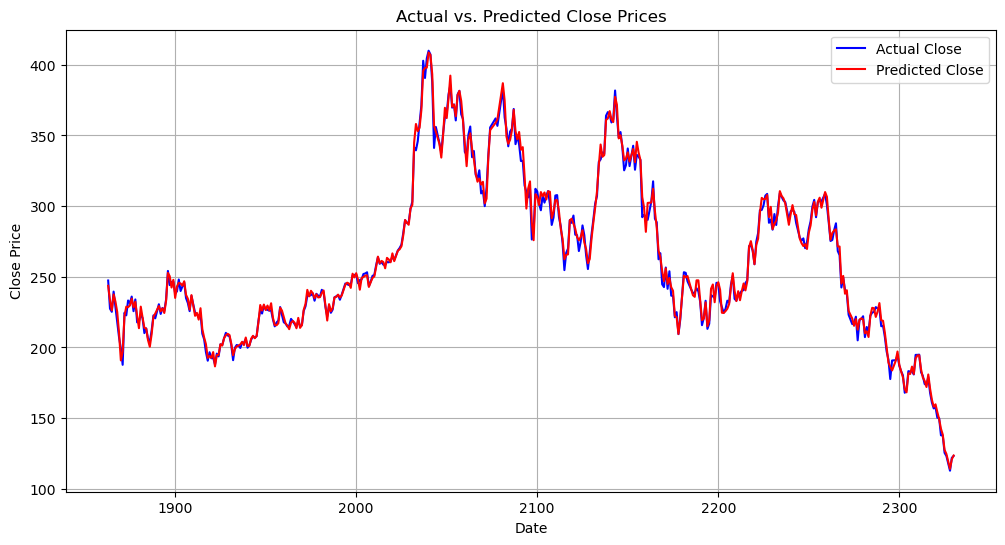

In [27]:
# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_close, label="Actual Close", color="b")
plt.plot(dates, predicted_close, label="Predicted Close", color="r")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Actual vs. Predicted Close Prices")
plt.legend()
plt.grid(True)
plt.show()